In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.fft import rfft, rfftfreq
from scipy.fft import fft2
from skimage.filters import window


import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())


def plot_temporal_profile(sta, dt):
    tap = sta.shape[-1]
#     figsize = (5.5,3.5)
#     plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    plt.ylabel('STA')
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    # print('PSNR = {:.2f}'.format(psnr(sta)))

    plt.title('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel('ms')
    
    
def plot_temporal_spectrum(sta, dt):
    wt = rfft(sta, axis=1)
    
    N = sta.shape[1]
    fs = rfftfreq(N, dt)
    
    plt.plot(fs, np.abs(wt.T), 'o-')
    plt.xlabel('Hz')
    plt.ylabel('FFT amplitude')

    box_off()


def plot_spatial_spectrum(sta_slice, windowing='hann', pixel_size=1, precision=2):
    assert len(sta_slice.shape)==2
    
    def set_ticks(ax, fs, precision=precision):
        ticks = range(0, len(fs))
        print_format = "{:." + str(precision) + "f}"
        ticklabels = [print_format.format(p) for p in (fs)]

        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
        ax.set_xlim(-0.5, len(fs)-0.5)
#         from matplotlib.ticker import FormatStrFormatter
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
        ax.set_ylim(-0.5, len(fs)-0.5)

        
    w = fft2(sta_slice * window(windowing, sta_slice.shape))

    fs = rfftfreq(sta_slice.shape[0])
    
    # crop and take abs w 
    abs_w = np.abs(w[:len(fs),:len(fs)])
    plt.imshow(abs_w, cmap='gray', origin='lower')

    set_ticks(plt.gca(), fs, precision=precision)
    
    plt.xlabel('frequency')
    plt.ylabel('frequency')
    
    abs_w[0,0] = - np.Inf
    idx_max = np.unravel_index(np.argmax(abs_w, axis=None), abs_w.shape)
    plt.plot(idx_max[1],idx_max[0], 'r*')
    
    
    
def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    
    plot_temporal_profile(sta, dt)
    
    
#     pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
#     if ylabel is not None:
#         plt.ylabel(ylabel)
#     print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     print('PSNR = {:.2f}'.format(psnr(sta)))
# #     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

Let's re-plot old Figure 3 (ON-OFF cell) for all the methods

## load data

In [3]:
# data_path = 'data'

# # dataset = '20201209'
# # width = 26
# # height = 26

# # dataset = '20201216'
# # width = 13
# # height = 13

# dataset = '20180626'
# width = 8
# height = 8
# fps = 10

In [4]:
# gaussian stim with the highest contrast
data_path = 'data_gaussian'
dataset = 'contrast100'
dataset = 'contrast50'

width = 8
height = 8
fps = 10

In [5]:
# different spatial & temporal resolutions (2018.08.28)
data_path = 'data_binary_stim'

# width = 8
# height = 8
# fps = 10

# width = 8
# height = 8
# fps = 25

# width = 13
# height = 13
# fps = 10

width = 26
height = 26
fps = 10

dataset = '20180828_{}pix_{}Hz'.format(width,fps)
dataset

'20180828_26pix_10Hz'

In [6]:
# cloud stim data (2021.01.13)
# ln -s ~/data/cloud_stim_data data_cloud_stim
data_path = 'data_cloud_stim'

dataset = '20210113'


In [7]:
data = np.load(os.path.join(data_path, dataset + '.npz'))
info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))


stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

111

In [8]:
if fps == 10:
    tap = 8
elif fps == 25:
    tap = 20

0.15537763539163732

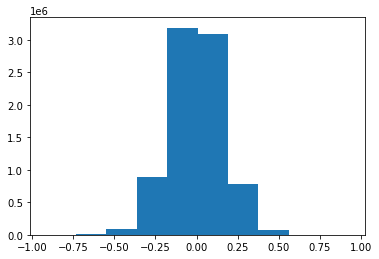

In [9]:
plt.hist(stim.ravel())
np.std(stim.ravel())

## Choose a channel

In [10]:
# choose a channel
ch_idx = info['channel'] == '33d'

channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

40    33d
Name: channel, dtype: object 40    ON
Name: cell_type, dtype: object


In [11]:
stim.shape, tap, spike_counts[ch_idx].shape

((12000, 676), 8, (1, 12000))

## first run STA to set ROI

In [12]:
spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim.T, spike_counts[ch_idx].ravel(), tap=tap)

sta = np.average(spike_triggered_stim, weights=weights, axis=0)

peak-to-peak diff. = 0.39


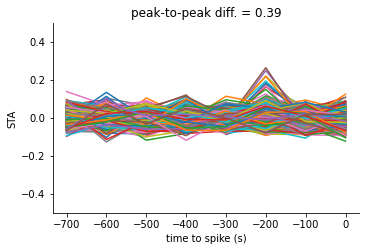

<Figure size 432x288 with 0 Axes>

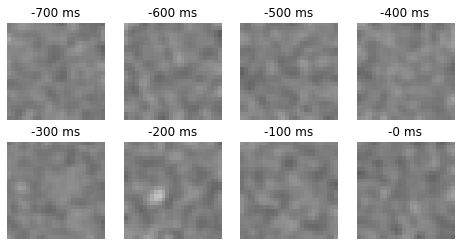

In [13]:
plot_spatio_temporal(sta, height, width, dt=1000/fps) #, ylabel=None, fig_basename=None): 

Text(0, 0.5, 'STA at pixel 295')

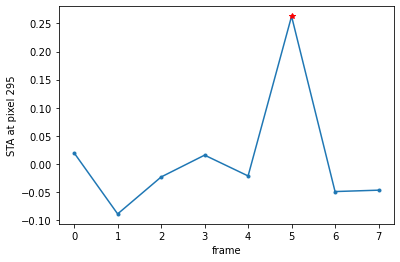

In [14]:
# find pixel with highest variance
idx_max_var = np.argmax(np.var(sta,axis=1))

temporal_profile = sta[idx_max_var,:]
plt.plot(temporal_profile, '.-')
idx_peak = np.argmax(np.abs(temporal_profile))

sta_slice = sta[:,idx_peak].reshape(height,width)
plt.plot(idx_peak, sta[idx_max_var, idx_peak], 'r*')
plt.xlabel('frame')
plt.ylabel('STA at pixel {}'.format(idx_max_var))

In [15]:
idx_max_var = np.unravel_index(idx_max_var, [height, width])
idx_max_var

(11, 9)

Text(0.5, 1.0, 'STA at -200 ms')

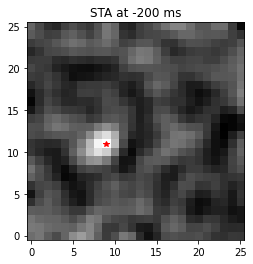

In [16]:
plt.imshow(sta[:,idx_peak].reshape(height,width), cmap='gray', origin='lower')
plt.plot(idx_max_var[1],idx_max_var[0], 'r*')
plt.title('STA at {:.0f} ms'.format(-(tap-idx_peak-1) * 1000/fps))

In [17]:
roi_radius = 3
roi_x = np.arange(idx_max_var[1]-roi_radius,idx_max_var[1]+roi_radius+1)
roi_y = np.arange(idx_max_var[0]-roi_radius,idx_max_var[0]+roi_radius+1)
roi_x, roi_y

## clip roi by the boundary
roi_x = [idx for idx in roi_x if (idx >=0 and idx <width)]
roi_y = [idx for idx in roi_y if (idx >=0 and idx <height)]

roi_width = len(roi_x)
roi_height = len(roi_y)
roi_x, roi_y

([6, 7, 8, 9, 10, 11, 12], [8, 9, 10, 11, 12, 13, 14])

In [18]:

cols = []
for x in roi_x:
    vertical_slice = stim.reshape((-1,height,width))[:,roi_y,x]
    cols.append(vertical_slice[:,:,np.newaxis])
    
stim_roi = np.concatenate(cols, axis=2)
stim_roi = stim_roi.reshape((stim_roi.shape[0], -1))
stim_roi.shape
# cols[0].shape
# stim_roi = stim.reshape((-1,height,width))[:,roi_y,roi_x]

(12000, 49)

In [19]:
# re-calc sta
spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim_roi, spike_counts[ch_idx].ravel(), tap=tap)

sta_roi = np.average(spike_triggered_stim, weights=weights, axis=0)

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

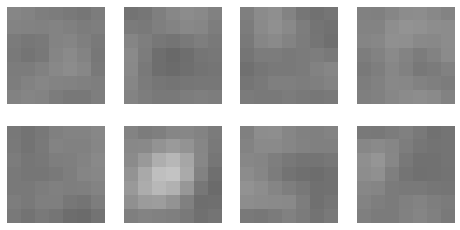

In [20]:
pysta.plot_stim_slices(sta_roi, roi_width, roi_height, vmin=-0.5, vmax=0.5)

## Now fit GLM

In [21]:
import glm

In [22]:
stim_roi.shape

(12000, 49)

In [23]:
k_est, dc_est, glm_results = glm.fit(stim_roi, tap, spike_counts[ch_idx].reshape((-1,1)))

# k_est = k_est.reshape((roi_height*roi_width,tap))
k_est = k_est.reshape((tap, roi_height*roi_width)).T

## GLM for all the pixels are too slow
# k_est, dc_est, glm_results = glm.fit(stim, tap, spike_counts[ch_idx].reshape((-1,1)))

In [24]:
dc_est

-19.368223009713645

In [25]:
np.max(k_est.ravel()), np.min(k_est.ravel())

(3944.4756744256697, -3273.8310280816263)

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

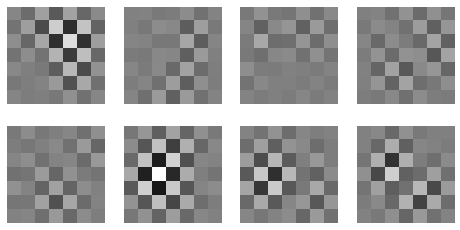

In [26]:
pysta.plot_stim_slices(k_est, roi_width, roi_height, vmin=-4000, vmax=4000)

In [27]:
k_est.shape

(49, 8)

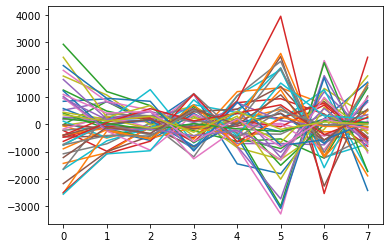

In [28]:
plt.plot(k_est.T)

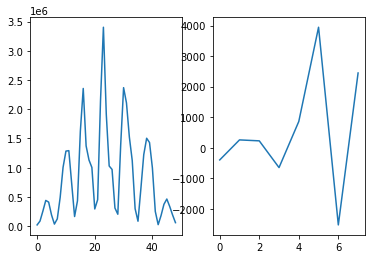

In [29]:
var_across_time = np.var(k_est, axis=1)

idx_max_var_across_time = np.argmax(var_across_time)

ref_temp_profile = k_est[idx_max_var_across_time,:]


plt.subplot(121)
plt.plot(var_across_time)

plt.subplot(122)
plt.plot(ref_temp_profile)




In [30]:
k_est.shape, ref_temp_profile.shape

((49, 8), (8,))

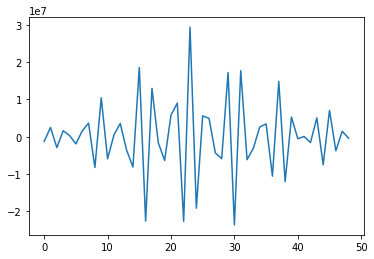

In [31]:
inner_product = np.dot(k_est, ref_temp_profile)
plt.plot(inner_product)

# flip k_est according to the sign
k_est = k_est * np.sign(inner_product.reshape((-1,1)))

(3, 2)


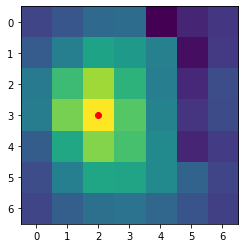

In [32]:
# convert to 2d idx
xy_idx_max_var_across_time = np.unravel_index(idx_max_var_across_time, [roi_height, roi_width])

print(xy_idx_max_var_across_time)

k_est_at_peak = k_est[:,idx_peak]
plt.imshow(k_est_at_peak.reshape(roi_height, roi_width))
plt.plot(xy_idx_max_var_across_time[1], xy_idx_max_var_across_time[0], 'ro')

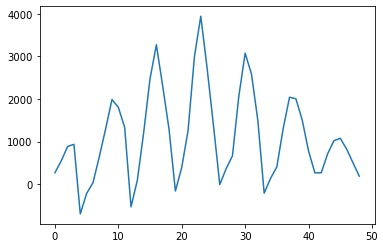

In [33]:
plt.plot(k_est_at_peak)

In [34]:
# re-plot

[<AxesSubplot:title={'center':'-700 ms'}>,
 <AxesSubplot:title={'center':'-600 ms'}>,
 <AxesSubplot:title={'center':'-500 ms'}>,
 <AxesSubplot:title={'center':'-400 ms'}>,
 <AxesSubplot:title={'center':'-300 ms'}>,
 <AxesSubplot:title={'center':'-200 ms'}>,
 <AxesSubplot:title={'center':'-100 ms'}>,
 <AxesSubplot:title={'center':'-0 ms'}>]

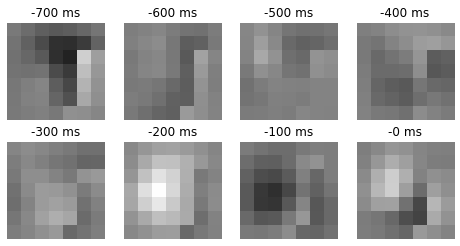

In [35]:
pysta.plot_stim_slices(k_est, roi_width, roi_height, vmin=-4000, vmax=4000, dt = 1000 / fps)

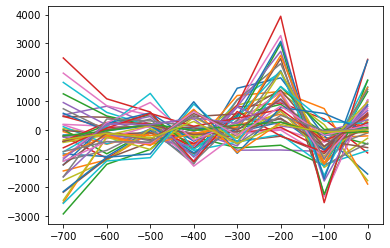

In [36]:
ts = -np.arange(tap) * 1000 / fps
ts = ts[::-1]

plt.plot(ts, k_est.T)